In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd

from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Activation, Dense, Dot
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import LearningRateScheduler

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Functions for visualising the output

import matplotlib.pyplot as plt

def draw_grid(grid, ax, title):
    for (x, y), val in grid.items():
        ax.text(x, y, str(val), ha='center', va='center', fontsize=8, fontweight='bold', color='white')
        ax.plot(x, y, marker='s', markersize=16, color='blue')
    
    ax.set_xlim(-11, 11)
    ax.set_ylim(-11, 11)
    ax.set_xticks(range(-10, 11))
    ax.set_yticks(range(-10, 11))
    ax.set_aspect('equal')
    ax.grid(True)
    ax.set_axisbelow(True)
    ax.set_title(title)

def convert_data_to_grid(k_list,label_list):
    grid = {}
    for i in range(len(k_list)):
        x, y = k_list[i]
        val = label_list[i]
        if val != 0:
            grid[(x, y)] = val
    return grid

# Setting up the model

In [3]:
num_hyps = 2
num_doms = 2*num_hyps
hyps_to_doms_params = [
[-3+1/2,2,2],
[-1+1/2,2,-2],
[-1+1/2,-2,2],
[1+1/2,-2,-2]]
# Note that the +1/2 terms mean that a boundary gets contributions from the polynomials on either side

temp = [
[1,0],
[0,1]]
temp_array = 200*np.array(temp)
weights_array = 200*np.transpose(hyps_to_doms_params)[1:]
bias_array = 200*np.transpose(hyps_to_doms_params)[0]

k_input = Input(shape=(2,), name='k_input')
doms_hidden = Dense(units=num_hyps, input_shape=(2,), 
        activation='sigmoid', use_bias=False,
        #trainable=False, weights=[temp_array],
        name='doms_hidden')(k_input)
# Layer for mapping the hyperplane conditions to region conditions:
doms_out = Dense(units=num_doms,
        activation='sigmoid',
        #trainable=False, weights=[weights_array, bias_array],
        bias_initializer='ones', name='doms_out')(doms_hidden)

k_quad_input = Input(shape=(6,), name='k_quad_input')
# Layer for mapping [1,k1,k2,k1^2,k1*k2,k2^2] to polynomials for each region:
pols_out = Dense(units=num_doms, input_shape=(6,), 
        use_bias=False, name='pols_out')(k_quad_input)

final_pol_out = Dot(axes=1)([doms_out,pols_out])

model = Model(inputs=[k_input,k_quad_input], outputs=[final_pol_out])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 k_input (InputLayer)           [(None, 2)]          0           []                               
                                                                                                  
 doms_hidden (Dense)            (None, 2)            4           ['k_input[0][0]']                
                                                                                                  
 k_quad_input (InputLayer)      [(None, 6)]          0           []                               
                                                                                                  
 doms_out (Dense)               (None, 4)            12          ['doms_hidden[0][0]']            
                                                                                              

# Training the model

First we read in the data. Note that the part of the network that builds the polynomials takes as input the values [1,k1,k2,k1^2,k1*k2,k2^2], so we create these from the data.

In [4]:
data = pd.read_csv('/kaggle/input/p1xp1-data/p1xp1_data.csv',names=["k1","k2","h0"])
data.head()

k_list = data.values[:,0:2]
label_list = data.values[:,2]

kquad_list = [None] * len(k_list)
for i in range(len(k_list)):
    k1 = k_list[i,0]
    k2 = k_list[i,1]
    kquad_list[i] = [1,k1,k2,k1**2,k1*k2,k2**2]
    
ks = np.array(k_list)
kquads = np.array(kquad_list)
labels = np.array(label_list)

In [5]:
def scheduler(epoch, lr):
    if epoch < 50:
        return lr
    else:
        return lr * tf.math.exp(-0.005)
    
callback = LearningRateScheduler(scheduler)


model.compile(optimizer=Adam(learning_rate=1), loss='mean_squared_error')

model.fit(x=[ks,kquads], y=labels, batch_size=100, epochs=200, callbacks=[callback], verbose=1)

Epoch 1/200
5/5 [==============================] - 1s 4ms/step - loss: 2810.9451 - lr: 1.0000
Epoch 2/200
5/5 [==============================] - 0s 3ms/step - loss: 582.6163 - lr: 1.0000
Epoch 3/200
5/5 [==============================] - 0s 2ms/step - loss: 580.4748 - lr: 1.0000
Epoch 4/200
5/5 [==============================] - 0s 2ms/step - loss: 580.4497 - lr: 1.0000
Epoch 5/200
5/5 [==============================] - 0s 2ms/step - loss: 580.4817 - lr: 1.0000
Epoch 6/200
5/5 [==============================] - 0s 2ms/step - loss: 580.4917 - lr: 1.0000
Epoch 7/200
5/5 [==============================] - 0s 2ms/step - loss: 580.4949 - lr: 1.0000
Epoch 8/200
5/5 [==============================] - 0s 2ms/step - loss: 580.4966 - lr: 1.0000
Epoch 9/200
5/5 [==============================] - 0s 2ms/step - loss: 580.4979 - lr: 1.0000
Epoch 10/200
5/5 [==============================] - 0s 2ms/step - loss: 580.4971 - lr: 1.0000
Epoch 11/200
5/5 [==============================] - 0s 2ms/step - lo

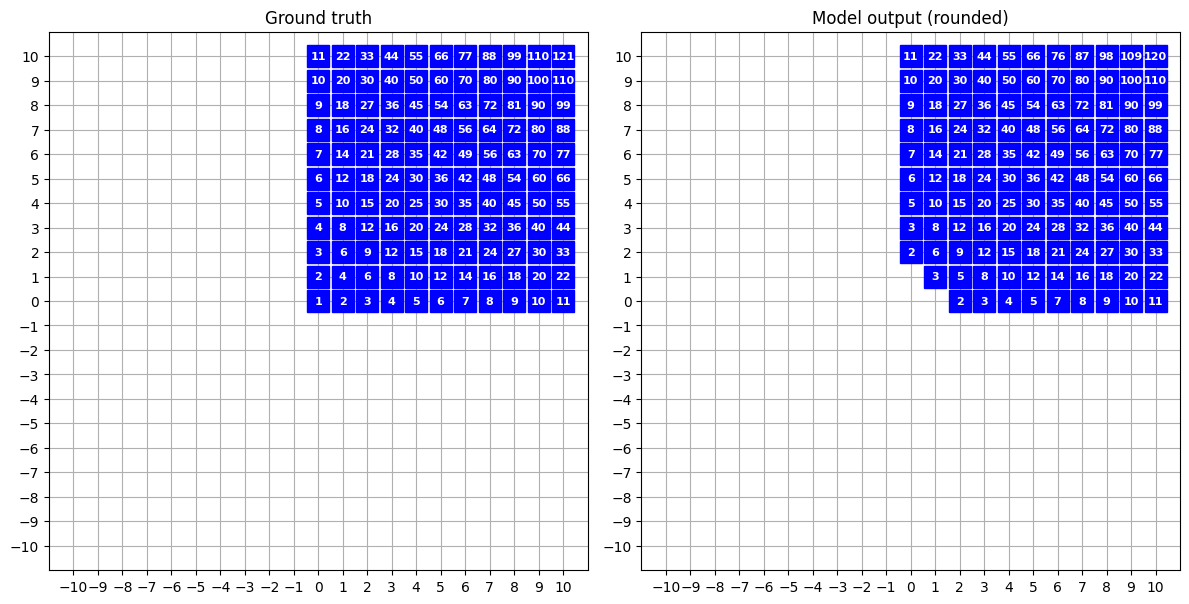

In [6]:

predictions = np.ndarray.flatten(np.rint(model.predict([ks,kquads],verbose=0)).astype(int))

# SOMETHING THAT WOULD BE NICE: RED BACKGROUNDS FOR THE SLOTS WHERE THE MODEL OUTPUT DIFFERS FROM THE GROUND TRUTH

grid1 = convert_data_to_grid(k_list,label_list)
title1 = "Ground truth"

grid2 = convert_data_to_grid(k_list,predictions)
title2 = "Model output (rounded)"


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 12))

draw_grid(grid1, ax1, title1)
draw_grid(grid2, ax2, title2)

plt.tight_layout()
plt.show()

## Checking individual layer behaviours

In [7]:
doms_hidden_weights = model.get_layer('doms_hidden').get_weights()
doms_out_weights = model.get_layer('doms_out').get_weights()
pols_out_weights = model.get_layer('pols_out').get_weights()

doms_hidden_copy = Dense(units=num_hyps, input_shape=(2,), 
        activation='sigmoid',
        weights=doms_hidden_weights,
        use_bias=False, name='doms_hidden_copy')(k_input)
doms_out_copy = Dense(units=num_doms,
        activation='sigmoid',
        trainable=False,
        weights=doms_out_weights,
        bias_initializer='ones', name='doms_out_copy')(doms_hidden)
pols_out_copy = Dense(units=num_doms, input_shape=(6,), 
        use_bias=False,
        weights=pols_out_weights,
        name='pols_out_copy')(k_quad_input)
final_pol_out_copy = Dot(axes=1)([doms_out,pols_out])

model_test = Model(inputs=[k_input], outputs=[doms_out_copy])

model_test.predict([[10,0]])

1/1 [==============================] - 0s 87ms/step


array([[0.13267344, 0.00031266, 0.00325003, 0.00033949]], dtype=float32)

In [8]:
print(bias_array)
print(weights_array)

[-500. -100. -100.  300.]
[[ 400.  400. -400. -400.]
 [ 400. -400.  400. -400.]]


# Checking the trained model

In [9]:
model.weights

[<tf.Variable 'doms_hidden/kernel:0' shape=(2, 2) dtype=float32, numpy=
 array([[-6.4485145, -1.772568 ],
        [-1.2725588, -8.898662 ]], dtype=float32)>,
 <tf.Variable 'doms_out/kernel:0' shape=(2, 4) dtype=float32, numpy=
 array([[-6.4849424, -9.62168  , -7.424181 , -8.639342 ],
        [-7.7003345, -8.582648 , -8.780983 , -9.221998 ]], dtype=float32)>,
 <tf.Variable 'doms_out/bias:0' shape=(4,) dtype=float32, numpy=array([-1.8775246, -8.070092 , -5.725836 , -7.9877267], dtype=float32)>,
 <tf.Variable 'pols_out/kernel:0' shape=(6, 4) dtype=float32, numpy=
 array([[ 0.81189233, -2.605822  , -0.7418573 , -2.6002083 ],
        [ 7.7662077 ,  3.557312  ,  8.264083  ,  4.4764695 ],
        [ 9.600996  ,  7.5755596 ,  9.698506  ,  7.522887  ],
        [ 0.04050346, -1.8726021 , -0.2667291 , -2.2231212 ],
        [ 7.294239  ,  0.28002578,  4.5340104 ,  1.4929259 ],
        [-0.12083264, -2.712273  , -1.2347921 , -2.484008  ]],
       dtype=float32)>]

In [10]:
temp = 10

print(ks[-10:])
print(labels[-10:])


model.predict([ks[-10:],kquads[-10:]])

[[10  1]
 [10  2]
 [10  3]
 [10  4]
 [10  5]
 [10  6]
 [10  7]
 [10  8]
 [10  9]
 [10 10]]
[ 22  33  44  55  66  77  88  99 110 121]
1/1 [==============================] - 0s 23ms/step


array([[ 22.138199],
       [ 33.214054],
       [ 44.246437],
       [ 55.235344],
       [ 66.18078 ],
       [ 77.08274 ],
       [ 87.941246],
       [ 98.75626 ],
       [109.527824],
       [120.2559  ]], dtype=float32)

In [11]:
model.predict([np.array([[0,0]]),np.array([[1,0,0,0,0,0]])])

1/1 [==============================] - 0s 26ms/step


array([[0.00010228]], dtype=float32)

In [12]:
temp = 10

print(ks[:10])
print(labels[:10])


model.predict([ks[:10],kquads[:10]])

[[-10 -10]
 [-10  -9]
 [-10  -8]
 [-10  -7]
 [-10  -6]
 [-10  -5]
 [-10  -4]
 [-10  -3]
 [-10  -2]
 [-10  -1]]
[0 0 0 0 0 0 0 0 0 0]
1/1 [==============================] - 0s 25ms/step


array([[ 5.80035339e-05],
       [ 5.15487409e-05],
       [ 4.50676125e-05],
       [ 3.85601597e-05],
       [ 3.20263789e-05],
       [ 2.54662664e-05],
       [ 1.88798240e-05],
       [ 1.22670535e-05],
       [ 5.62795412e-06],
       [-1.03747436e-06]], dtype=float32)

In [13]:
type(k_list[0])

numpy.ndarray